### 1.0 | Assignment 4: Evaluating Random Forest  and Gradient Boosting Regressors

### Overview:

The management team of a real state company is interested in understanding if machine learning techniques can accurately predict residential housing market values to supplement more conventional methods. Using a sample of labeled real estate data for the city of Boston as training data, models will be assessed based on the minimzed RMSE acheived.

As with any machine learning model build, the data must be first analyzed, scaled, encoded and imputed, if necassary. An initial analysis of the data showed that the number of rooms in a given house and the % of local poplation in a lower economic class had the strongest correlation to the response variable, median house value. Next, the data was scaled across all continuous variables and cateogrical variables were encoded. No values needed to be imputed.

Previous attempts were made to generate a meaningful predictive model using linear regression methods. The results indicated that linear regression was a viable option with an RMSE of 4.87. In this phase of the project, tree-based methods were evaluated to determine if they provided greater predictive power, as measured by a lower RMSE. Four models were considered: Random Forest Regression, Gradient Boosting Regression, Ada Boost Regression and Extra Gradient Boosting Regression. All four models showed a significant improvement in performance compared to the linear models with RMSE values ranging from 3.75 (Gradient Boosting) to 3.29 (Extra Gradie Boosting). In addition, an average of all four model's predicted values was considered with the idea being that the aggregated estimators would cancel out any weaknesses in each individual model. This aggregated model beat all 4 of the individual models with an RMSE value of 3.08. It is recommended that the aggregate model be used. Combining all 4 models into a stacked model is likely to be more robust in evaluating future test values than relying on a single model.

### 1.1 | Load Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #scale any continuous fields
from sklearn.preprocessing import Imputer #impute any missing values
from sklearn.preprocessing import LabelBinarizer
#################################################
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics #to evaluate model performances

import warnings
warnings.filterwarnings("ignore")

### 1.2 | Import Data

In [2]:
file = "C:/Users/David/OneDrive/MSDS/MSDS422/Week4/boston.csv"
df = pd.read_csv(file,sep = ',')
print('df rows:',len(df))
df.head()

df rows: 506


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### 1.3 | Data Pre-Processing

In [3]:
#convert dependent variable to log value
#df['mv'] = np.log(df['mv'])

#isolate cat/cont/response fields
cat_fields = ['chas']
cont_fields = ['crim','zn','indus','nox','rooms','age','dis','rad','tax','ptratio','lstat']
response_fields = ['mv']

df[cat_fields+cont_fields+response_fields].head()

,chas,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
#describe cat fields
df[cat_fields].describe()

,chas
count,506.000000
mean,0.069170
std,0.253994
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
#describe cont fields
df[cont_fields+response_fields].describe()

,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


### 1.3 | Split into Training and Test Data

In [6]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = .3

#split data into train and test sets
xtrain,xtest,ytrain,ytest=train_test_split(df[cat_fields+cont_fields],df['mv'],
                                               test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [7]:
#confirm split went according to plan. both y values are close to the mean value
print("Row count of Xtrain:",len(xtrain))
print("Row count of Ytrain:",len(ytrain),"/ Avg Market Value: ",np.mean(ytrain))
print("Row count of Xtest:",len(xtest))
print("Row count of Ytest:",len(ytest),"/ Avg Market Value: ",np.mean(ytest))

Row count of Xtrain: 354
Row count of Ytrain: 354 / Avg Market Value:  23.023163841807907
Row count of Xtest: 152
Row count of Ytest: 152 / Avg Market Value:  21.377631578947362


### 1.4 | Scale Test and Training Data 

In [8]:
#scale training data separate from test so as to not influence scaling
train_scaled = pd.DataFrame(StandardScaler().fit_transform(xtrain[cont_fields]),
                   columns = xtrain[cont_fields].columns, index = xtrain.index)

xtrain = pd.concat([xtrain[cat_fields],train_scaled],axis = 1)

#scale test data likewise
test_scaled = pd.DataFrame(StandardScaler().fit_transform(xtest[cont_fields]),
                   columns = xtest[cont_fields].columns, index = xtest.index)

xtest = pd.concat([xtest[cat_fields],test_scaled],axis = 1)

print("Test Data shape:",xtest.shape)
print("Training Data shape: ",xtrain.shape)
xtrain.head()

Test Data shape: (152, 12)
Training Data shape:  (354, 12)


,chas,crim,zn,indus,nox,rooms,age,dis,rad,tax,ptratio,lstat
5,0,-0.414259,-0.505125,-1.292142,-0.851085,0.145264,-0.365584,1.081628,-0.746179,-1.112790,0.187271,-1.015316
116,0,-0.402008,-0.505125,-0.162083,-0.087967,-0.208401,0.133941,-0.487876,-0.398464,0.150088,-0.212090,-0.053663
45,0,-0.397211,-0.505125,-0.609489,-0.936828,-0.896237,-1.266900,0.628596,-0.746179,-1.046639,-0.167716,-0.311324
16,0,-0.290936,-0.505125,-0.431970,-0.165136,-0.543965,-1.429789,0.345133,-0.630274,-0.601625,1.207859,-0.822422
468,0,1.457816,-0.505125,1.005500,0.194987,-0.556496,0.079645,-0.403892,1.687825,1.557294,0.852872,0.803800


### 1.5 | One Hot Encoding of Categorical Variables

In [9]:
#this method is tricky since I want to one hot encode across a combined test and training set. If I were to encode test
#and training in isolation then I would run the risk of some values showing up only in one of the sets resulting in a mismatched
#number of columns

#define variable for identifying test and train
xtrain['train'] = 1
xtest['train'] = 0

#Combine test and train data
combined = pd.concat([xtrain,xtest],axis = 0)

#isolate categorical variables
cat_df = combined[cat_fields]

#one hot encode
cat_df_encoded = pd.get_dummies(cat_df,drop_first = True)

combined_2 = pd.concat([cat_df_encoded,combined[cont_fields],combined['train']],axis = 1)

#split combined data set back to train and test
xtrain = combined_2[combined_2['train'] == 1]
xtest  = combined_2[combined_2['train'] == 0]
#remove train field defined earlier
xtrain.drop('train',axis = 1,inplace = True)
xtest.drop('train',axis = 1, inplace = True)

print("Test Data shape:",xtest.shape)
print("Training Data shape: ",xtrain.shape)
#Check the columns are equal and and the rows counts remained the same

Test Data shape: (152, 12)
Training Data shape:  (354, 12)


### 1.6 | Model I: Random Forest Regression

In [13]:
model1 = RandomForestRegressor(random_state = RANDOM_STATE)

param_grid = [{
    "n_estimators"       :[10, 25, 50, 100,150,200],
    "max_depth"          :[None, 2, 5, 10, 15],
    "max_features"       :['log2'],
    "min_samples_split"  :[2,4],
    "bootstrap"          :[True],
    "warm_start"         :[True, False],
    }]

grid_search = GridSearchCV(model1,param_grid,cv = 5)
rf = grid_search.fit(xtrain,ytrain)
#optimized hyperparameters
rf.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 150,
 'warm_start': True}

In [14]:
best_model_rf = rf.best_estimator_
rf_pred = best_model_rf.predict(xtest)

#Examine Results
print("Random Forest Regressor")
print("---------------------------")
print("Number of Features : {}".format(best_model_rf.n_features_))
print("Root mean squared error : {}".format(np.sqrt(metrics.mean_squared_error(ytest, rf_pred)).round(2)))
print("R-squared : {}".format(metrics.r2_score(ytest, rf_pred).round(2)))

Random Forest Regressor
---------------------------
Number of Features : 12
Root mean squared error : 3.29
R-squared : 0.86


Text(0.5, 0, 'Variables')

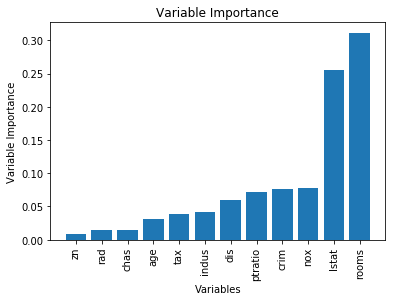

In [15]:
coeff = pd.concat([pd.Series(xtrain.columns),pd.Series(best_model_rf.feature_importances_)],axis = 1)
coeff.columns = ['Variable','Variable Importance']
coeff = coeff.sort_values('Variable Importance')

plt.bar(coeff['Variable'],coeff['Variable Importance'])
plt.title('Variable Importance')
plt.xticks(rotation = 90)
plt.ylabel('Variable Importance')
plt.xlabel('Variables')

Text(0, 0.5, 'Actual Value')

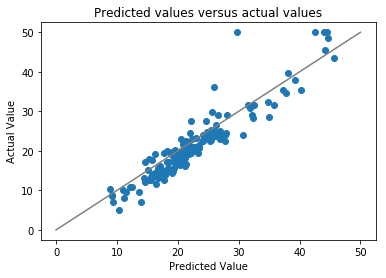

In [16]:
#convert back to regular values from log
plt.scatter(rf_pred,ytest)
plt.plot([0, 50], [0, 50],'grey')
plt.title('Predicted values versus actual values')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

### 1.7 | Model II: Gradient Boost Regression

In [17]:
model2 = GradientBoostingRegressor(random_state = RANDOM_STATE)

param_grid = [{
    "loss"               :['ls', 'lad', 'huber', 'quantile'],
    "learning_rate"      :[.50, 1.0, 1.5],
    "max_features"       :['log2'],
    "n_estimators"       :[10, 25, 50, 100],
    "criterion"          :["mse"],
    "warm_start"         :[True, False],
    }]

grid_search = GridSearchCV(model2,param_grid,cv = 5)
gb = grid_search.fit(xtrain,ytrain)
#optimized hyperparameters
gb.best_params_

{'criterion': 'mse',
 'learning_rate': 0.5,
 'loss': 'huber',
 'max_features': 'log2',
 'n_estimators': 50,
 'warm_start': True}

In [18]:
best_model_gb = gb.best_estimator_
gb_pred = best_model_gb.predict(xtest)

#Examine Results
print("Gradient Boost Regressor")
print("---------------------------")
print("Number of Features : {}".format(best_model_gb.n_features_))
print("Root mean squared error : {}".format(np.sqrt(metrics.mean_squared_error(ytest, gb_pred)).round(2)))
print("R-squared : {}".format(metrics.r2_score(ytest, gb_pred).round(2)))

Gradient Boost Regressor
---------------------------
Number of Features : 12
Root mean squared error : 3.75
R-squared : 0.81


Text(0.5, 0, 'Variables')

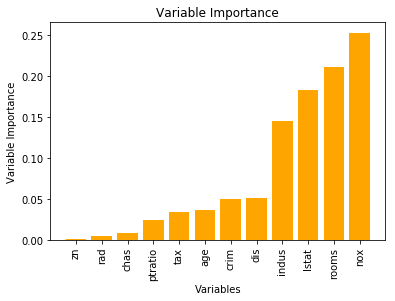

In [19]:
coeff = pd.concat([pd.Series(xtrain.columns),pd.Series(best_model_gb.feature_importances_)],axis = 1)
coeff.columns = ['Variable','Variable Importance']
coeff = coeff.sort_values('Variable Importance')

plt.bar(coeff['Variable'],coeff['Variable Importance'],color = 'Orange')
plt.title('Variable Importance')
plt.xticks(rotation = 90)
plt.ylabel('Variable Importance')
plt.xlabel('Variables')

Text(0, 0.5, 'Actual Value')

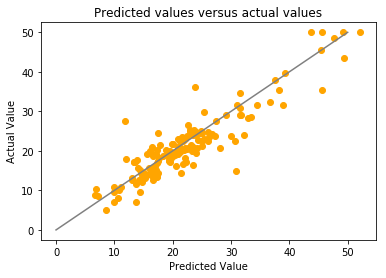

In [20]:
#convert back to regular values from log
plt.scatter(gb_pred,ytest,color = 'Orange')
plt.plot([0, 50], [0, 50],'grey')
plt.title('Predicted values versus actual values')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

### 1.8 | Model III: AdaBoost Regression

In [21]:
model3 = AdaBoostRegressor(random_state = RANDOM_STATE)

param_grid = [{
    "loss"               :['linear','square','exponential'],
    "learning_rate"      :[.50, 1.0, 1.5,2],
    "n_estimators"       :[10, 25, 50, 100,150]
    }]

grid_search = GridSearchCV(model3,param_grid,cv = 5)
ab = grid_search.fit(xtrain,ytrain)
#optimized hyperparameters
ab.best_params_

{'learning_rate': 2, 'loss': 'exponential', 'n_estimators': 100}

In [22]:
best_model_ab = ab.best_estimator_
ab_pred = best_model_ab.predict(xtest)

#Examine Results
print("AdaBoost Regressor")
print("---------------------------")
print("Root mean squared error : {}".format(np.sqrt(metrics.mean_squared_error(ytest, ab_pred)).round(2)))
print("R-squared : {}".format(metrics.r2_score(ytest, ab_pred).round(2)))

AdaBoost Regressor
---------------------------
Root mean squared error : 3.44
R-squared : 0.84


Text(0.5, 0, 'Variables')

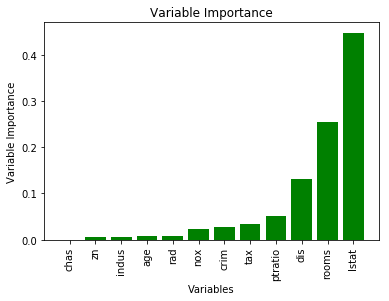

In [23]:
coeff = pd.concat([pd.Series(xtrain.columns),pd.Series(best_model_ab.feature_importances_)],axis = 1)
coeff.columns = ['Variable','Variable Importance']
coeff = coeff.sort_values('Variable Importance')

plt.bar(coeff['Variable'],coeff['Variable Importance'],color = 'Green')
plt.title('Variable Importance')
plt.xticks(rotation = 90)
plt.ylabel('Variable Importance')
plt.xlabel('Variables')

Text(0, 0.5, 'Actual Value')

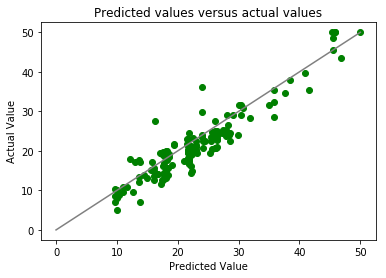

In [24]:
#convert back to regular values from log
plt.scatter(ab_pred,ytest,color = 'Green')
plt.plot([0, 50], [0, 50],'grey')
plt.title('Predicted values versus actual values')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

### 1.9 | Model IV: XGBoost Regression

In [25]:
model4 = XGBRegressor(random_state = RANDOM_STATE)

#param_grid = [{
#    "loss"               :['linear','square','exponential'],
#    "learning_rate"      :[.50, 1.0, 1.5,2],
#    "n_estimators"       :[10, 25, 50, 100,150]
#    }]

#grid_search = GridSearchCV(model3,param_grid,cv = 5)
#xg = model4.fit(xtrain,ytrain)
#optimized hyperparameters
#xg.best_params_


param_grid = [{
    "loss"               :['ls', 'lad', 'huber', 'quantile'],
    "learning_rate"      :[.50, 1.0, 1.5],
    "max_features"       :['log2'],
    "n_estimators"       :[10, 25, 50, 100],
    "criterion"          :["mse"],
    "warm_start"         :[True, False],
    }]

grid_search = GridSearchCV(model4,param_grid,cv = 5)
xg = grid_search.fit(xtrain,ytrain)
#optimized hyperparameters
xg.best_params_

{'criterion': 'mse',
 'learning_rate': 0.5,
 'loss': 'ls',
 'max_features': 'log2',
 'n_estimators': 25,
 'warm_start': True}

In [26]:
xg_pred = xg.predict(xtest)

#Examine Results
print("AdaBoost Regressor")
print("---------------------------")
print("Root mean squared error : {}".format(np.sqrt(metrics.mean_squared_error(ytest, xg_pred)).round(2)))
print("R-squared : {}".format(metrics.r2_score(ytest, xg_pred).round(2)))

AdaBoost Regressor
---------------------------
Root mean squared error : 3.29
R-squared : 0.86


Text(0, 0.5, 'Actual Value')

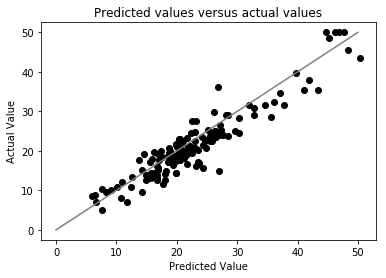

In [27]:
#convert back to regular values from log
plt.scatter(xg_pred,ytest,color = 'black')
plt.plot([0, 50], [0, 50],'grey')
plt.title('Predicted values versus actual values')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

### 2.0 Voting Model Classifier

In [38]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[('rf', rf), ('gb', gb), ('ab', ab),('xg',xg)],voting='hard')
vote.fit(xtrain.astype('int'), ytrain.astype('int'))

vote_pred = vote.predict(xtest.astype('int'))

#Examine Results
print("Voting Model")
print("---------------------------")
print("Root mean squared error : {}".format(np.sqrt(metrics.mean_squared_error(ytest, vote_pred)).round(2)))
print("R-squared : {}".format(metrics.r2_score(ytest, vote_pred).round(2)))

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

### 2.0 | Analysis of Models

In [37]:
print('RMSE of Models')
print('--------------------------------------')
print("Random Forest  : {}".format(np.sqrt(metrics.mean_squared_error(ytest, rf_pred)).round(2)))
print("Gradient Boost : {}".format(np.sqrt(metrics.mean_squared_error(ytest, gb_pred)).round(2)))
print("AdaBoost       : {}".format(np.sqrt(metrics.mean_squared_error(ytest, ab_pred)).round(2)))
print("XGBoost        : {}".format(np.sqrt(metrics.mean_squared_error(ytest, xg_pred)).round(2)))
print("--------------------------------------")
print("Mean of Models : {}".format(np.sqrt(metrics.mean_squared_error(ytest, (rf_pred+gb_pred+ab_pred+xg_pred)/4)).round(2)))

RMSE of Models
--------------------------------------
Random Forest  : 3.29
Gradient Boost : 3.75
AdaBoost       : 3.44
XGBoost        : 3.29
--------------------------------------
Mean of Models : 3.08


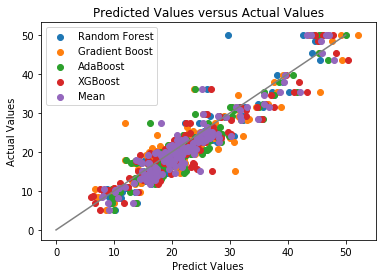

In [44]:
mean_pred = (rf_pred+gb_pred+ab_pred+xg_pred)/4
for i,j in zip([rf_pred,gb_pred,ab_pred,xg_pred,mean_pred],['Random Forest','Gradient Boost','AdaBoost','XGBoost','Mean']):
    plt.scatter(i,ytest,label = j)
plt.plot([0, 50], [0, 50],'grey')    
plt.title('Predicted Values versus Actual Values')
plt.xlabel('Predict Values')
plt.ylabel('Actual Values')
plt.legend()